# Experimentos

## Imports

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import pandas as pd
from tqdm.notebook import tqdm

/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import mahotas
import mahotas.features

In [3]:
%run utils.py

In [4]:
%run utils_experiments.py

In [5]:
# Usada para testear
image_name = 'FM000020_03' # piñera

## Probar funciones utils

TODO: Todo lo que está bajo este título se podría borrar, son sólo pruebas de funciones (i.e. no es necesario ejecutarlo).

### Cargar una imagen del dataset

Original shape:  (256, 256, 3)
Gray shape:  (256, 256)
Crop+gray shape:  (128, 256)


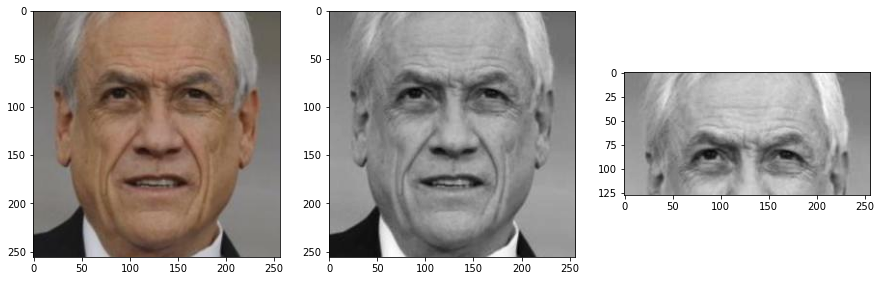

In [15]:
img = load_image(image_name)
print('Original shape: ', img.shape)

img_gray = load_image(image_name, gray=True)
print('Gray shape: ', img_gray.shape)

img_crop = load_image(image_name, gray=True, crop=True)
print('Crop+gray shape: ', img_crop.shape)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.imshow(img_gray, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(img_crop, cmap='gray')

### Cargar un dataset de las N primeras imagenes de un dataset

In [6]:
datasetA = load_dataset(16, gray=True, crop=True)
# Lista de: [image, image_name, i_image (label/persona), j (image_number 1-6)]

len(datasetA)

96

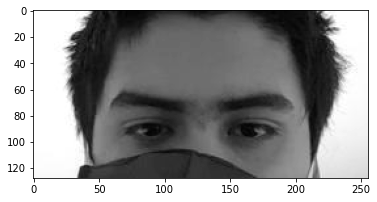

In [15]:
plt.imshow(datasetA[5][0], cmap='gray')

### Plotear matriz de confusión

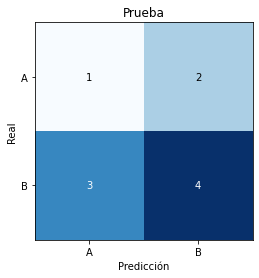

In [16]:
plot_cm(np.array([[1, 2], [3, 4]]), title='Prueba', labels=['A', 'B'])

## Crear DataFrame con features

Se crea un `pd.DataFrame` que contiene los features y las labels de cada imagen.
Se puede crear un DF para cada dataset (A, B, C, D).

Más adelante se le van agregando los features a este DataFrame, para evitar recalcularlos.


In [6]:
N_PEOPLE_A = 16
N_PEOPLE_B = 40
N_PEOPLE_C = 100
N_PEOPLE_D = 166

In [7]:
datasetA = load_dataset(N_PEOPLE_A, gray=True, crop=True)
datasetA_color = load_dataset(N_PEOPLE_A, gray=False, crop=True)
print(len(datasetA))

df_A = create_df(datasetA)
df_A.head(6)

96


,label,image_number
FM000001_01,1,1
FM000001_02,1,2
FM000001_03,1,3
FM000001_04,1,4
FM000001_05,1,5
FM000001_06,1,6


In [7]:
datasetB = load_dataset(N_PEOPLE_B, gray=True, crop=True)
datasetB_color = load_dataset(N_PEOPLE_B, gray=False, crop=True)

df_B = create_df(datasetB)
print(len(df_B))
df_B.head(6)

240


,label,image_number
FM000001_01,1,1
FM000001_02,1,2
FM000001_03,1,3
FM000001_04,1,4
FM000001_05,1,5
FM000001_06,1,6


## Calcular features

### LBP

Se aplica LBP de la librería `skimage`.

In [8]:
from skimage.feature import local_binary_pattern

#### Ejemplo LBP

In [19]:
image = load_image('FM000020_03', gray=True, crop=True)
image.shape

(128, 256)

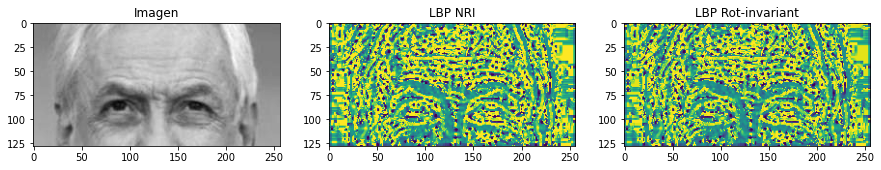

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Imagen')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('LBP NRI')
radius = 3
plt.imshow(local_binary_pattern(image, 8*radius, radius, method='nri_uniform'))

plt.subplot(1, 3, 3)
plt.title('LBP Rot-invariant')
radius = 3
plt.imshow(local_binary_pattern(image, 8*radius, radius, method='uniform'))

#### Calcular LBP para todo el dataset

In [11]:
def calculate_lbp(image, n_vertical=4, n_horizontal=8, radius=1, method='nri_uniform'):
    """Se calcula LBP para una imagen, considerando crops horizontales y verticales."""
    
    global_features = []

    for horizontal_patch in np.array_split(image, n_horizontal, axis=1):
        for patch in np.array_split(horizontal_patch, n_vertical, axis=0):
            local_features = local_binary_pattern(patch, 8*radius, radius, method=method)

            # Computar histograma
            n_bins = int(local_features.max() + 1)
            lbp_hist, _ = np.histogram(local_features, bins=n_bins)
            
            global_features.append(lbp_hist)
            
    # Pad local_features to reach same size
    max_feature = max(len(arr) for arr in global_features)
    global_features = np.array([np.pad(arr, (0, max_feature - len(arr))) for arr in global_features])

    return global_features.flatten()

In [12]:
def calculate_lbp_color(image, **kwargs):
    """Calcula LBP para cada color, y concatena los resultados."""
    assert len(image.shape) == 3, 'Color image needed'

    feats = [calculate_lbp(image[:, :, ch], **kwargs) for ch in range(3)]
    feats = np.array(feats).flatten()

    return feats

In [13]:
LBP_CONFIGS = {
    '4-8': { 'n_vertical': 4, 'n_horizontal': 8 },
    '2-6': { 'n_vertical': 2, 'n_horizontal': 6 },
    '4-4': { 'n_vertical': 4, 'n_horizontal': 4 },
} 

In [14]:
%%time

lbp_df = calculate_feature_multiple_df(datasetB, calculate_lbp, LBP_CONFIGS, basename='lbp',
                                       method='nri_uniform', radius=1)
lbp_df.head()

Calculating lbp-4-8
Calculating lbp-2-6
Calculating lbp-4-4
CPU times: user 7.77 s, sys: 32.7 ms, total: 7.8 s
Wall time: 7.82 s


,lbp-4-8_0,lbp-4-8_1,lbp-4-8_2,lbp-4-8_3,lbp-4-8_4,lbp-4-8_5,lbp-4-8_6,lbp-4-8_7,lbp-4-8_8,lbp-4-8_9,...,lbp-4-4_934,lbp-4-4_935,lbp-4-4_936,lbp-4-4_937,lbp-4-4_938,lbp-4-4_939,lbp-4-4_940,lbp-4-4_941,lbp-4-4_942,lbp-4-4_943
FM000001_01,24,9,0,6,1,18,0,9,0,2,...,6,13,20,1,31,19,13,5,442,94
FM000001_02,9,17,0,14,0,11,0,8,0,8,...,16,16,4,11,9,17,7,15,60,104
FM000001_03,30,6,0,20,0,8,0,32,0,7,...,9,22,8,10,9,21,10,5,93,133
FM000001_04,27,32,0,3,2,23,1,11,1,11,...,0,2,7,1,26,7,5,0,1054,41
FM000001_05,29,16,0,4,1,20,1,2,2,1,...,4,11,6,4,22,21,9,2,793,58


In [17]:
%%time

lbp_color_df = calculate_feature_multiple_df(datasetA_color, calculate_lbp_color, LBP_CONFIGS,
                                             basename='lbp-color',
                                             method='nri_uniform', radius=1)
lbp_color_df.head()

Calculating lbp-color-4-8
Calculating lbp-color-2-6
Calculating lbp-color-4-4
CPU times: user 9.03 s, sys: 0 ns, total: 9.03 s
Wall time: 9.05 s


,lbp-color-4-8_0,lbp-color-4-8_1,lbp-color-4-8_2,lbp-color-4-8_3,lbp-color-4-8_4,lbp-color-4-8_5,lbp-color-4-8_6,lbp-color-4-8_7,lbp-color-4-8_8,lbp-color-4-8_9,...,lbp-color-4-4_2822,lbp-color-4-4_2823,lbp-color-4-4_2824,lbp-color-4-4_2825,lbp-color-4-4_2826,lbp-color-4-4_2827,lbp-color-4-4_2828,lbp-color-4-4_2829,lbp-color-4-4_2830,lbp-color-4-4_2831
FM000001_01,29,8,0,9,2,14,0,8,0,5,...,7,21,20,2,25,18,15,5,467,158
FM000001_02,11,16,0,18,0,9,0,7,0,1,...,10,9,1,12,4,19,7,10,76,122
FM000001_03,30,4,0,23,0,7,0,34,0,6,...,9,31,12,9,5,27,7,5,100,146
FM000001_04,31,30,1,4,2,25,1,12,2,9,...,0,2,10,1,26,9,3,0,1055,39
FM000001_05,28,17,0,4,1,33,1,2,1,0,...,4,12,3,4,16,23,13,3,766,66


In [15]:
df_B = df_B.merge(lbp_df, right_index=True, left_index=True)
# df_A = df_A.merge(lbp_color_df, right_index=True, left_index=True)

df_B.head()

,label,image_number,lbp-4-8_0,lbp-4-8_1,lbp-4-8_2,lbp-4-8_3,lbp-4-8_4,lbp-4-8_5,lbp-4-8_6,lbp-4-8_7,...,lbp-4-4_934,lbp-4-4_935,lbp-4-4_936,lbp-4-4_937,lbp-4-4_938,lbp-4-4_939,lbp-4-4_940,lbp-4-4_941,lbp-4-4_942,lbp-4-4_943
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,6,13,20,1,31,19,13,5,442,94
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,16,16,4,11,9,17,7,15,60,104
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,9,22,8,10,9,21,10,5,93,133
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,0,2,7,1,26,7,5,0,1054,41
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,4,11,6,4,22,21,9,2,793,58


### Gabor

In [26]:
from pybalu import feature_extraction as balu

ModuleNotFoundError: No module named 'pybalu.feature_extraction.geometric_utils'

#### Ejemplo

<BarContainer object of 67 artists>

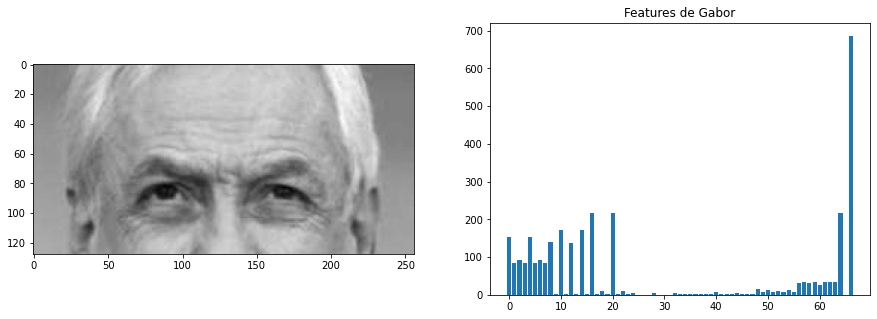

In [19]:
image = load_image(image_name, gray=True, crop=True)

gabor = balu.gabor_features(image, labels=False)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Features de Gabor')
plt.bar(range(len(gabor)), gabor)

#### Calcular para todo el dataset

TODO: se podrían agregar más hiperparámetros, por ahora sólo probé los valores por defecto de pybalu.

In [7]:
def calculate_gabor(image):
    """Se calculan features de Gabor para una imagen."""
    gabor = balu.gabor_features(image, labels=False)
    return gabor

In [8]:
%%time

gabor_df = calculate_feature_df(datasetA, calculate_gabor, 'gabor')

df_A = df_A.merge(gabor_df, right_index=True, left_index=True)
df_A.head()

Calculating gabor


NameError: name 'balu' is not defined

### HoG

In [8]:
import skimage.feature

In [9]:
def calculate_hog(image, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=False, **kwargs):
    """Calcular vector de caracteristicas de HoG para una imagen."""
    return skimage.feature.hog(image,
                               pixels_per_cell=pixels_per_cell,
                               cells_per_block=cells_per_block,
                               feature_vector=True,
                               visualize=visualize,
                               **kwargs,
                              )

#### Ejemplo

In [25]:
image = load_image(image_name)

hog = calculate_hog(image)
hog.shape

(9216,)

<BarContainer object of 9216 artists>

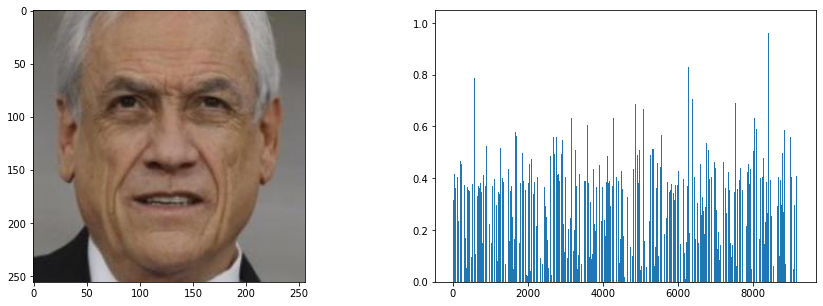

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.bar(range(len(hog)), hog)

#### Calcular HoG para todo el dataset (gris y color)

In [10]:
HOG_CONFIGS = {
#     'v1': {'pixels_per_cell': (8, 8), 'cells_per_block':(4, 4)},
    'v2': {'pixels_per_cell': (8, 8), 'cells_per_block':(4, 4), 'transform_sqrt': True},
#     'v3': {'pixels_per_cell': (16, 16), 'cells_per_block':(4, 4), 'transform_sqrt': True},
#     'v4': {'pixels_per_cell': (32, 32), 'cells_per_block':(4, 4), 'transform_sqrt': True},
#     'v5': {'pixels_per_cell': (8, 8), 'cells_per_block':(8, 8), 'transform_sqrt': True},
#     'v6': {'pixels_per_cell': (4, 8), 'cells_per_block':(4, 8), 'transform_sqrt': True},
#     'v7': {'pixels_per_cell': (8, 16), 'cells_per_block':(4, 8), 'transform_sqrt': True},
#     'v8': {'pixels_per_cell': (8, 8), 'cells_per_block':(2, 2)},
#     'v9': {'pixels_per_cell': (8, 8), 'cells_per_block':(2, 2), 'transform_sqrt': True},
#     'v10': {'pixels_per_cell': (8, 8), 'cells_per_block':(1, 1), 'transform_sqrt': True},
}

In [13]:
%%time

hog_df = calculate_feature_multiple_df(datasetA, calculate_hog, HOG_CONFIGS, basename='hog', multichannel=False)
hog_df.head()

Calculating hog-v2
Calculating hog-v5
Calculating hog-v7
CPU times: user 10.4 s, sys: 207 ms, total: 10.6 s
Wall time: 10.6 s


,hog-v2_0,hog-v2_1,hog-v2_2,hog-v2_3,hog-v2_4,hog-v2_5,hog-v2_6,hog-v2_7,hog-v2_8,hog-v2_9,...,hog-v7_33686,hog-v7_33687,hog-v7_33688,hog-v7_33689,hog-v7_33690,hog-v7_33691,hog-v7_33692,hog-v7_33693,hog-v7_33694,hog-v7_33695
FM000001_01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004457,...,0.000000,0.001678,0.000000,0.000000,0.001047,0.017444,0.000000,0.000000,0.000000,0.000000
FM000001_02,0.103017,0.068132,0.115138,0.159180,0.090918,0.025562,0.032885,0.016723,0.048984,0.087705,...,0.032548,0.017500,0.012979,0.013524,0.016306,0.036716,0.018192,0.013928,0.015810,0.002463
FM000001_03,0.116251,0.095676,0.157047,0.136501,0.239135,0.107798,0.106758,0.167744,0.073710,0.239135,...,0.226065,0.018405,0.010735,0.018677,0.010572,0.021669,0.004459,0.010269,0.019535,0.006608
FM000001_04,0.101368,0.010659,0.001212,0.000000,0.003856,0.002185,0.002798,0.012909,0.058251,0.068889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FM000001_05,0.002039,0.000000,0.001838,0.000000,0.071377,0.002280,0.002884,0.000000,0.001612,0.001020,...,0.000000,0.002293,0.000000,0.000714,0.000000,0.005985,0.000000,0.000495,0.000000,0.000000


In [11]:
%%time

hog_color_df = calculate_feature_multiple_df(datasetA_color, calculate_hog, HOG_CONFIGS, basename='hog-color',
                                             multichannel=True)
hog_color_df.head()

Calculating hog-color-v2
CPU times: user 2.38 s, sys: 31.4 ms, total: 2.41 s
Wall time: 2.41 s


,hog-color-v2_0,hog-color-v2_1,hog-color-v2_2,hog-color-v2_3,hog-color-v2_4,hog-color-v2_5,hog-color-v2_6,hog-color-v2_7,hog-color-v2_8,hog-color-v2_9,...,hog-color-v2_54278,hog-color-v2_54279,hog-color-v2_54280,hog-color-v2_54281,hog-color-v2_54282,hog-color-v2_54283,hog-color-v2_54284,hog-color-v2_54285,hog-color-v2_54286,hog-color-v2_54287
FM000001_01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.234161,0.000000,0.000000,0.000000,0.000000
FM000001_02,0.108572,0.072784,0.112895,0.157649,0.109572,0.019131,0.032165,0.015373,0.046907,0.098825,...,0.004539,0.036414,0.028192,0.005431,0.060768,0.114244,0.059838,0.046123,0.017664,0.000000
FM000001_03,0.137719,0.086321,0.164701,0.135325,0.240212,0.109219,0.105737,0.167649,0.070941,0.240212,...,0.001480,0.016342,0.003188,0.006510,0.013524,0.029907,0.007984,0.025213,0.035239,0.009061
FM000001_04,0.117400,0.012835,0.001281,0.000000,0.004119,0.002359,0.000000,0.020217,0.066043,0.095879,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FM000001_05,0.000474,0.000000,0.000000,0.002203,0.077660,0.002118,0.002679,0.001707,0.001497,0.005531,...,0.000000,0.053972,0.000000,0.015266,0.000000,0.075561,0.000000,0.000000,0.000000,0.000000


In [12]:
# df_A = df_A.merge(hog_df, right_index=True, left_index=True)
df_A = df_A.merge(hog_color_df, right_index=True, left_index=True)
df_A.head()

,label,image_number,hog-color-v2_0,hog-color-v2_1,hog-color-v2_2,hog-color-v2_3,hog-color-v2_4,hog-color-v2_5,hog-color-v2_6,hog-color-v2_7,...,hog-color-v2_54278,hog-color-v2_54279,hog-color-v2_54280,hog-color-v2_54281,hog-color-v2_54282,hog-color-v2_54283,hog-color-v2_54284,hog-color-v2_54285,hog-color-v2_54286,hog-color-v2_54287
FM000001_01,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.234161,0.000000,0.000000,0.000000,0.000000
FM000001_02,1,2,0.108572,0.072784,0.112895,0.157649,0.109572,0.019131,0.032165,0.015373,...,0.004539,0.036414,0.028192,0.005431,0.060768,0.114244,0.059838,0.046123,0.017664,0.000000
FM000001_03,1,3,0.137719,0.086321,0.164701,0.135325,0.240212,0.109219,0.105737,0.167649,...,0.001480,0.016342,0.003188,0.006510,0.013524,0.029907,0.007984,0.025213,0.035239,0.009061
FM000001_04,1,4,0.117400,0.012835,0.001281,0.000000,0.004119,0.002359,0.000000,0.020217,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FM000001_05,1,5,0.000474,0.000000,0.000000,0.002203,0.077660,0.002118,0.002679,0.001707,...,0.000000,0.053972,0.000000,0.015266,0.000000,0.075561,0.000000,0.000000,0.000000,0.000000


##### Ejemplo

In [53]:
image = load_image(image_name, crop=True, gray=False)
image.shape

(128, 256, 3)

In [54]:
hog = calculate_hog(image, **HOG_CONFIGS['v2'])
len(hog)

54288

### Haralick

TODO: también se pueden probar más combinaciones de hiper-parámetros.

In [27]:
from pybalu import feature_extraction as balu

In [34]:
def calculate_haralick(image, distance=[1, 3, 8, 20]):
    """Se calcula un vector de características de Haralick para una imagen.
    
    Funciona solo con imagenes en tono de grises.
    """
    har = balu.haralick_features(image, distance=distance)
    
    return har

#### Ejemplo

In [32]:
image = load_image(image_name, gray=True)
image.shape

(256, 256)

In [33]:
har = calculate_haralick(image)
len(har)

112

<BarContainer object of 112 artists>

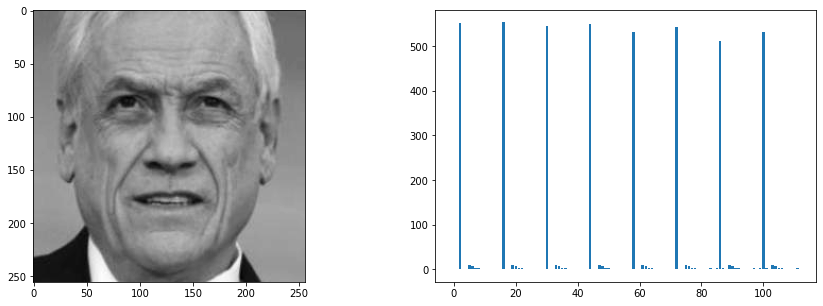

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.bar(range(len(har)), har)

#### Calcular Haralick para todo el dataset

In [36]:
%%time

haralick_df = calculate_feature_df(datasetA, calculate_haralick, 'haralick')

df_A = df_A.merge(haralick_df, right_index=True, left_index=True)
df_A.head()

Calculating haralick
CPU times: user 1.57 s, sys: 459 ms, total: 2.03 s
Wall time: 1.06 s


,label,image_number,lbp-4-8_0,lbp-4-8_1,lbp-4-8_2,lbp-4-8_3,lbp-4-8_4,lbp-4-8_5,lbp-4-8_6,lbp-4-8_7,...,haralick_102,haralick_103,haralick_104,haralick_105,haralick_106,haralick_107,haralick_108,haralick_109,haralick_110,haralick_111
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,0.702851,8.379669,6.290701,2.190982,3.017540,0.041066,1.688582,0.298658,0.606052,1.262888
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,0.582302,9.895166,7.655817,2.249493,3.419914,0.021327,1.750417,0.097105,0.279537,1.387097
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,0.624571,8.421179,6.354381,2.201073,3.347930,0.028251,1.652116,0.120142,0.328648,1.220561
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,0.644832,10.076585,7.832322,2.301889,3.504951,0.031538,1.610312,0.195041,0.493492,1.335625
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,0.661396,7.864132,5.712508,2.265340,3.319862,0.032194,1.726176,0.214327,0.520734,1.200304


### Cuantización features

Usado para features tipo SIFT, SURF.

NOTA(pablo): esta función podría moverse a `utils.py`.

In [233]:
from sklearn.cluster import KMeans, MeanShift

In [234]:
def feature_quantization(dataset, features, method='k-means', n_clusters=5, **kwargs):
    """Perform quantization of features via k-means.
    
    Args:
        dataset -- dataset retornado por `load_dataset()`
        features -- list of features of shape (n_points, n_features)
    """
    # Select clustering method
    if method == 'k-means':
        cluster_model = KMeans(n_clusters, **kwargs)
    elif method == 'mean-shift':
        cluster_model = MeanShift(**kwargs)
    else:
        raise Exception(f'Method not found: {method}')

    # Select train images and features
    image_names = [(idx, s[1]) for idx, s in enumerate(dataset)]
    train_features = [features[idx] for idx, name in image_names if int(name[-1]) <= 3]

    train_features = np.vstack(train_features)
    
    # Fit train data
    cluster_model.fit(train_features)
    
    # Actual amount of clusters (compatible with all cluster algorithms)
    n_clusters = cluster_model.cluster_centers_.shape[0]

    # Predict for each image
    final_features = []

    for image_features in features:
        # image_features shape: n_points, n_features
        
        prediction = cluster_model.predict(image_features)
        # shape: n_points, n_clusters
        
        hist, _ = np.histogram(prediction, bins=range(n_clusters + 1))
        # hist shape: n_clusters

        final_features.append(hist)
        
    final_features = np.array(final_features)
    # shape: n_images, n_clusters

    return final_features

### SIFT

In [291]:
import pysift

In [316]:
def calculate_sift(img_gray, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5, *args, **kwargs):
    keypoints, descriptors = pysift.computeKeypointsAndDescriptors(img_gray,
                                                                   sigma=sigma,
                                                                   num_intervals=num_intervals,
                                                                   assumed_blur=assumed_blur,
                                                                   image_border_width=image_border_width)
    # descriptors shape: n_points, n_features
    # keypoints: list of cv2.KeyPoint objects (len == n_points)
    return keypoints, descriptors

In [275]:
%run utils.py

In [295]:
sift_features = calculate_features(datasetA, calculate_sift, show=True)
len(sift_features)

Calculating features


In [334]:
filepath = 'features/datasetA_sift_feats.dat'

In [335]:
pickle_sift(sift_features, filepath)

In [337]:
sift_features = unpickle_sift(filepath)
len(sift_features)

96

In [338]:
sift_descriptors = [desc for _, desc in sift_features]
len(sift_descriptors)

96

In [339]:
set(f.shape for f in sift_descriptors)

{(21, 128),
 (30, 128),
 (32, 128),
 (35, 128),
 (39, 128),
 (45, 128),
 (46, 128),
 (49, 128),
 (50, 128),
 (51, 128),
 (55, 128),
 (56, 128),
 (57, 128),
 (58, 128),
 (61, 128),
 (64, 128),
 (65, 128),
 (66, 128),
 (68, 128),
 (71, 128),
 (72, 128),
 (74, 128),
 (75, 128),
 (76, 128),
 (77, 128),
 (78, 128),
 (79, 128),
 (81, 128),
 (82, 128),
 (83, 128),
 (84, 128),
 (85, 128),
 (86, 128),
 (87, 128),
 (88, 128),
 (89, 128),
 (90, 128),
 (92, 128),
 (94, 128),
 (95, 128),
 (96, 128),
 (99, 128),
 (100, 128),
 (101, 128),
 (105, 128),
 (106, 128),
 (107, 128),
 (109, 128),
 (111, 128),
 (113, 128),
 (114, 128),
 (117, 128),
 (119, 128),
 (124, 128),
 (126, 128),
 (128, 128),
 (131, 128),
 (139, 128),
 (142, 128),
 (143, 128),
 (144, 128),
 (147, 128),
 (151, 128),
 (153, 128),
 (155, 128),
 (166, 128),
 (168, 128),
 (170, 128),
 (190, 128),
 (197, 128),
 (199, 128),
 (218, 128),
 (237, 128),
 (277, 128),
 (288, 128),
 (290, 128)}

In [303]:
%%time

sift_quantized = feature_quantization(datasetA, sift_features, method='k-means', n_clusters=100)
sift_quantized.shape

(96, 100)

In [304]:
sift_df = features_to_df(datasetA, sift_quantized, 'sift')
sift_df.head()

,sift_0,sift_1,sift_2,sift_3,sift_4,sift_5,sift_6,sift_7,sift_8,sift_9,...,sift_90,sift_91,sift_92,sift_93,sift_94,sift_95,sift_96,sift_97,sift_98,sift_99
FM000001_01,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,2,4,0,3
FM000001_02,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,2
FM000001_03,0,7,0,0,1,0,1,0,0,0,...,0,0,2,1,2,0,1,0,0,7
FM000001_04,2,2,1,1,0,1,1,0,0,0,...,0,0,0,1,4,1,1,0,0,5
FM000001_05,0,3,1,2,1,1,1,0,0,0,...,0,0,0,1,2,1,1,1,0,4


In [306]:
df_A = df_A.merge(sift_df, right_index=True, left_index=True)
df_A.head()

,label,image_number,sift_0,sift_1,sift_2,sift_3,sift_4,sift_5,sift_6,sift_7,...,sift_90,sift_91,sift_92,sift_93,sift_94,sift_95,sift_96,sift_97,sift_98,sift_99
FM000001_01,1,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,2,4,0,3
FM000001_02,1,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,2
FM000001_03,1,3,0,7,0,0,1,0,1,0,...,0,0,2,1,2,0,1,0,0,7
FM000001_04,1,4,2,2,1,1,0,1,1,0,...,0,0,0,1,4,1,1,0,0,5
FM000001_05,1,5,0,3,1,2,1,1,1,0,...,0,0,0,1,2,1,1,1,0,4


### Threshold-Adjacency-Statistics


In [122]:
import mahotas
import mahotas.features

In [123]:
calculate_tas = lambda img: mahotas.features.tas(img)  # Threshold Adjacency Statistics
tas_df = calculate_feature_df(datasetA, calculate_tas, 'tas')

df_A = df_A.merge(tas_df, right_index=True, left_index=True)
df_A.head()


Calculating tas


,label,image_number,matrix_0,matrix_1,matrix_2,matrix_3,matrix_4,matrix_5,matrix_6,matrix_7,...,tas_44,tas_45,tas_46,tas_47,tas_48,tas_49,tas_50,tas_51,tas_52,tas_53
FM000001_01,1,1,64.760784,80.132314,21.257566,79.741176,205.628722,80.132314,58.913907,79.741176,...,0.000046,0.924791,0.017199,0.013841,0.026359,0.010788,0.002646,0.002951,0.001119,0.000305
FM000001_02,1,2,41.458241,72.050085,31.018270,69.922742,152.620294,72.050085,113.026011,69.922742,...,0.000000,0.919652,0.020805,0.016851,0.027489,0.012426,0.001836,0.000800,0.000094,0.000047
FM000001_03,1,3,72.509191,84.377181,34.868910,120.809943,255.073880,84.377181,119.508867,120.809943,...,0.000045,0.878116,0.029953,0.024301,0.042449,0.018524,0.004521,0.001633,0.000314,0.000188
FM000001_04,1,4,54.972120,96.246843,48.484437,93.668180,168.044537,96.246843,133.716611,93.668180,...,0.000173,0.901389,0.025356,0.020781,0.029104,0.015268,0.004520,0.002315,0.001213,0.000055
FM000001_05,1,5,68.597978,101.088992,43.526267,101.753528,194.987974,101.088992,115.842665,101.753528,...,0.000143,0.895226,0.026280,0.020019,0.035911,0.015754,0.004403,0.001376,0.000963,0.000069


### Speeded-Up-Robust-Features


In [246]:
from mahotas.features import surf

In [247]:
def calculate_surf(img, nr_octaves = 4, nr_scales = 6):
    _surf = surf.surf(img, nr_octaves = nr_octaves, nr_scales = nr_scales, max_points = 35, descriptor_only=True)
    # _surf = _surf.flatten()
    # _surf = np.pad(_surf, pad_width= (0,64-_surf.size), mode='constant', constant_values=0)
    #print(_surf)
    return _surf #.flatten()

In [248]:
%run utils.py

In [263]:
%%time

surf_features = calculate_features(datasetA, calculate_surf)

Calculating features
CPU times: user 918 ms, sys: 3.8 ms, total: 921 ms
Wall time: 921 ms


In [264]:
set(f.shape for f in surf_features)

{(8, 64),
 (9, 64),
 (11, 64),
 (12, 64),
 (13, 64),
 (14, 64),
 (15, 64),
 (16, 64),
 (17, 64),
 (18, 64),
 (19, 64),
 (20, 64),
 (21, 64),
 (22, 64),
 (23, 64),
 (24, 64)}

In [265]:
surf_features = feature_quantization(datasetA, surf_features, method='k-means', n_clusters=100)
surf_df = features_to_df(datasetA, surf_features, 'surf')
surf_df.head()

,surf_0,surf_1,surf_2,surf_3,surf_4,surf_5,surf_6,surf_7,surf_8,surf_9,...,surf_90,surf_91,surf_92,surf_93,surf_94,surf_95,surf_96,surf_97,surf_98,surf_99
FM000001_01,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
FM000001_02,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
FM000001_03,0,0,0,2,0,1,0,0,1,2,...,0,0,0,1,0,0,0,0,0,0
FM000001_04,0,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
FM000001_05,0,0,0,0,0,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0


In [268]:
df_A = df_A.merge(surf_df, right_index=True, left_index=True)
df_A.head()

,label,image_number,surf_0,surf_1,surf_2,surf_3,surf_4,surf_5,surf_6,surf_7,...,surf_90,surf_91,surf_92,surf_93,surf_94,surf_95,surf_96,surf_97,surf_98,surf_99
FM000001_01,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
FM000001_02,1,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
FM000001_03,1,3,0,0,0,2,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
FM000001_04,1,4,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FM000001_05,1,5,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### Blob Detection

In [119]:
from skimage.feature import (blob_dog, corner_foerstner, greycomatrix,
                             greycoprops, hog, local_binary_pattern)
from skimage.exposure import equalize_hist

def calculate_blob_stats(img):
        # Blob detection
        _blob_dog = blob_dog(equalize_hist(img))

        #Mean and std
        if _blob_dog.size > 0 and _blob_dog[:, 2].size > 0:
            blob_mean = np.mean(_blob_dog[:, 2])
            blob_std = np.std(_blob_dog[:, 2])
        else:
            blob_mean = 0
            blob_std = 0
        blob_stat = np.array([blob_mean, blob_std])
        return blob_stat


In [120]:
blob_df = calculate_feature_df(datasetA, calculate_blob_stats, 'blob')

df_A = df_A.merge(blob_df, right_index=True, left_index=True)
df_A.head()

Calculating blob


c:\users\yerko\appdata\local\programs\python\python37\lib\site-packages\skimage\feature\blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
c:\users\yerko\appdata\local\programs\python\python37\lib\site-packages\skimage\feature\blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
c:\users\yerko\appdata\local\programs\python\python37\lib\site-packages\skimage\feature\blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
c:\users\yerko\appdata\local\programs\python\python37\lib\site-packages\skimage\feature\blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


,label,image_number,matrix_0,matrix_1,matrix_2,matrix_3,matrix_4,matrix_5,matrix_6,matrix_7,...,matrix_92,matrix_93,matrix_94,matrix_95,matrix_96,matrix_97,matrix_98,matrix_99,blob_0,blob_1
FM000001_01,1,1,64.760784,80.132314,21.257566,79.741176,205.628722,80.132314,58.913907,79.741176,...,0.045903,0.037901,0.040531,0.038141,0.042515,0.034504,0.037898,0.035103,34.896609,8.053064
FM000001_02,1,2,41.458241,72.050085,31.018270,69.922742,152.620294,72.050085,113.026011,69.922742,...,0.024435,0.021648,0.022436,0.021819,0.022875,0.020047,0.021493,0.020177,26.038239,9.579423
FM000001_03,1,3,72.509191,84.377181,34.868910,120.809943,255.073880,84.377181,119.508867,120.809943,...,0.017010,0.016993,0.017795,0.016143,0.016025,0.015648,0.016799,0.014800,32.380027,11.152748
FM000001_04,1,4,54.972120,96.246843,48.484437,93.668180,168.044537,96.246843,133.716611,93.668180,...,0.065349,0.064466,0.069689,0.065429,0.062315,0.060521,0.068277,0.062325,32.380027,11.152748
FM000001_05,1,5,68.597978,101.088992,43.526267,101.753528,194.987974,101.088992,115.842665,101.753528,...,0.036365,0.030464,0.030776,0.030208,0.034280,0.027954,0.029565,0.027687,34.896609,8.053064


In [111]:
def co_matrix(img, distance_list = [1, 2, 3, 4, 5], angle_list = [0, np.pi/4, np.pi/2, 3*np.pi/4]):
        matrix = greycomatrix(img, distance_list,  angle_list)
        con = greycoprops(matrix, 'contrast').flatten()  # Contrast
        dis = greycoprops(matrix, 'dissimilarity').flatten()  # Dissimilarity
        homo = greycoprops(matrix, 'homogeneity').flatten()  # Homogeneity
        asm = greycoprops(matrix, 'ASM').flatten()  # ASM
        energy = np.sqrt(asm)  # Energy
        return np.array([con,dis,homo,asm,energy]).flatten()

In [112]:
matrix_df = calculate_feature_df(datasetA, co_matrix, 'matrix')

df_A = df_A.merge(matrix_df, right_index=True, left_index=True)
df_A.head()

Calculating matrix


,label,image_number,matrix_0,matrix_1,matrix_2,matrix_3,matrix_4,matrix_5,matrix_6,matrix_7,...,matrix_90,matrix_91,matrix_92,matrix_93,matrix_94,matrix_95,matrix_96,matrix_97,matrix_98,matrix_99
FM000001_01,1,1,64.760784,80.132314,21.257566,79.741176,205.628722,80.132314,58.913907,79.741176,...,0.043732,0.042569,0.045903,0.037901,0.040531,0.038141,0.042515,0.034504,0.037898,0.035103
FM000001_02,1,2,41.458241,72.050085,31.018270,69.922742,152.620294,72.050085,113.026011,69.922742,...,0.024191,0.024693,0.024435,0.021648,0.022436,0.021819,0.022875,0.020047,0.021493,0.020177
FM000001_03,1,3,72.509191,84.377181,34.868910,120.809943,255.073880,84.377181,119.508867,120.809943,...,0.019349,0.018250,0.017010,0.016993,0.017795,0.016143,0.016025,0.015648,0.016799,0.014800
FM000001_04,1,4,54.972120,96.246843,48.484437,93.668180,168.044537,96.246843,133.716611,93.668180,...,0.071557,0.068518,0.065349,0.064466,0.069689,0.065429,0.062315,0.060521,0.068277,0.062325
FM000001_05,1,5,68.597978,101.088992,43.526267,101.753528,194.987974,101.088992,115.842665,101.753528,...,0.033243,0.033475,0.036365,0.030464,0.030776,0.030208,0.034280,0.027954,0.029565,0.027687


## Normalizar

Normalización de columnas.
* Se normalizan todas las columnas de features en el rango (0,1).
* Para calcular el rango de normalización se usan sólo las imágenes de training.
* Por defecto, se mantienen las columnas normalizadas en el DataFrame y las no normalizadas también, con el sufijo `'_nonorm'`. Esto para que también se puedan hacer pruebas con las columnas no normalizadas, si se desea.

(Ver función `normalize_df()` en `utils.py`).

Nota(pablo): Esta función debería ser ejecutada sólo una vez, no estoy 100% seguro si el dataframe quedará feo con algo como 'hog_3_nonorm_nonorm_nonorm' (no debería, pero no lo he probado tanto).

In [13]:
df_A = normalize_df(df_A)
df_A.head()

,label,image_number,hog-color-v2_0_nonorm,hog-color-v2_1_nonorm,hog-color-v2_2_nonorm,hog-color-v2_3_nonorm,hog-color-v2_4_nonorm,hog-color-v2_5_nonorm,hog-color-v2_6_nonorm,hog-color-v2_7_nonorm,...,hog-color-v2_54278,hog-color-v2_54279,hog-color-v2_54280,hog-color-v2_54281,hog-color-v2_54282,hog-color-v2_54283,hog-color-v2_54284,hog-color-v2_54285,hog-color-v2_54286,hog-color-v2_54287
FM000001_01,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.678994,0.000000,0.000000,0.000000,0.000000
FM000001_02,1,2,0.108572,0.072784,0.112895,0.157649,0.109572,0.019131,0.032165,0.015373,...,0.019867,0.120110,0.111519,0.038801,0.258865,0.331273,0.205441,0.220753,0.139023,0.000000
FM000001_03,1,3,0.137719,0.086321,0.164701,0.135325,0.240212,0.109219,0.105737,0.167649,...,0.006477,0.053903,0.012612,0.046511,0.057610,0.086721,0.027411,0.120673,0.277350,0.032287
FM000001_04,1,4,0.117400,0.012835,0.001281,0.000000,0.004119,0.002359,0.000000,0.020217,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FM000001_05,1,5,0.000474,0.000000,0.000000,0.002203,0.077660,0.002118,0.002679,0.001707,...,0.000000,0.178025,0.000000,0.109071,0.000000,0.219102,0.000000,0.000000,0.000000,0.000000


In [16]:
df_B = normalize_df(df_B)
df_B.head()

,label,image_number,lbp-4-8_0_nonorm,lbp-4-8_1_nonorm,lbp-4-8_2_nonorm,lbp-4-8_3_nonorm,lbp-4-8_4_nonorm,lbp-4-8_5_nonorm,lbp-4-8_6_nonorm,lbp-4-8_7_nonorm,...,lbp-4-4_934,lbp-4-4_935,lbp-4-4_936,lbp-4-4_937,lbp-4-4_938,lbp-4-4_939,lbp-4-4_940,lbp-4-4_941,lbp-4-4_942,lbp-4-4_943
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,0.131579,0.062992,0.133803,0.015385,0.416667,0.142857,0.309524,0.086207,0.320124,0.201780
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,0.394737,0.086614,0.021127,0.169231,0.111111,0.125000,0.166667,0.258621,0.023310,0.231454
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,0.210526,0.133858,0.049296,0.153846,0.111111,0.160714,0.238095,0.086207,0.048951,0.317507
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,-0.026316,-0.023622,0.042254,0.015385,0.347222,0.035714,0.119048,0.000000,0.795649,0.044510
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,0.078947,0.047244,0.035211,0.061538,0.291667,0.160714,0.214286,0.034483,0.592852,0.094955


## Clean

Código para hacer clean de las columnas.

Nota(pablo): no se puede hacer clean de tantas columnas a la vez.
Sólo con features de HoG pueden haber 500k features, y se necesitaría 1Tb de memoria para calcular la matriz de correlación entre los features (ese valor lo estima la librería).

In [54]:
from pybalu.feature_selection import clean

In [56]:
features = [col for col in df_A.columns if '_nonorm' not in col and col != 'label' and col != 'image_number' and 'pca' not in col]
len(features)

54288

In [57]:
%%time

clean_cols_idx = clean(df_A[features].to_numpy())
clean_cols_idx = set(clean_cols_idx)

leftout_features = [name for idx, name in enumerate(original_features) if idx not in clean_cols_idx]
clean_features = [name for idx, name in enumerate(original_features) if idx in clean_cols_idx]
len(clean_features), len(leftout_features)

MemoryError: Unable to allocate 22.0 GiB for an array with shape (54288, 54288) and data type float64

## Selección y transformación de Features

### SFS

In [23]:
from pybalu.feature_selection import sfs

In [25]:
train, val, test = split_train_val_test(df_A)
train.head()

,label,image_number,hog-color-v2_0_nonorm,hog-color-v2_1_nonorm,hog-color-v2_2_nonorm,hog-color-v2_3_nonorm,hog-color-v2_4_nonorm,hog-color-v2_5_nonorm,hog-color-v2_6_nonorm,hog-color-v2_7_nonorm,...,hog-color-v2_54278,hog-color-v2_54279,hog-color-v2_54280,hog-color-v2_54281,hog-color-v2_54282,hog-color-v2_54283,hog-color-v2_54284,hog-color-v2_54285,hog-color-v2_54286,hog-color-v2_54287
FM000001_01,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.678994,0.000000,0.000000,0.000000,0.000000
FM000001_02,1,2,0.108572,0.072784,0.112895,0.157649,0.109572,0.019131,0.032165,0.015373,...,0.019867,0.120110,0.111519,0.038801,0.258865,0.331273,0.205441,0.220753,0.139023,0.000000
FM000001_03,1,3,0.137719,0.086321,0.164701,0.135325,0.240212,0.109219,0.105737,0.167649,...,0.006477,0.053903,0.012612,0.046511,0.057610,0.086721,0.027411,0.120673,0.277350,0.032287
FM000002_01,2,1,0.093295,0.090953,0.104582,0.029157,0.095846,0.044667,0.066701,0.016078,...,0.283917,0.173995,0.215660,0.109307,0.214214,0.110493,0.279331,0.215575,0.501488,0.065260
FM000002_02,2,2,0.069706,0.011685,0.023548,0.055580,0.066515,0.060083,0.088619,0.092612,...,0.219003,0.759156,0.534703,0.409287,0.117582,0.507980,0.000000,0.297908,0.972962,0.791179


In [48]:
hog_cols = get_cols_startwith(df_A, 'hog', color=True)
len(hog_cols)

54288

In [59]:
cols_idxs = sfs(train[hog_cols].to_numpy(), train['label'].to_numpy(), 50, method='fisher', show=True)
cols = [hog_cols[idx] for idx in cols_idxs]
len(cols)

Selecting Features: 100%|██████████| 50.0/50.0 [2:51:02<00:00, 205s/ features]  


50

In [60]:
cols

['hog-color-v2_49135',
 'hog-color-v2_20737',
 'hog-color-v2_31216',
 'hog-color-v2_31685',
 'hog-color-v2_40878',
 'hog-color-v2_11191',
 'hog-color-v2_11654',
 'hog-color-v2_20819',
 'hog-color-v2_26746',
 'hog-color-v2_9662',
 'hog-color-v2_38848',
 'hog-color-v2_23572',
 'hog-color-v2_15460',
 'hog-color-v2_942',
 'hog-color-v2_19655',
 'hog-color-v2_46439',
 'hog-color-v2_49832',
 'hog-color-v2_25348',
 'hog-color-v2_7019',
 'hog-color-v2_36510',
 'hog-color-v2_45906',
 'hog-color-v2_39509',
 'hog-color-v2_49129',
 'hog-color-v2_21700',
 'hog-color-v2_44787',
 'hog-color-v2_34062',
 'hog-color-v2_3016',
 'hog-color-v2_41789',
 'hog-color-v2_43988',
 'hog-color-v2_47145',
 'hog-color-v2_1919',
 'hog-color-v2_6689',
 'hog-color-v2_353',
 'hog-color-v2_34740',
 'hog-color-v2_40178',
 'hog-color-v2_30717',
 'hog-color-v2_39346',
 'hog-color-v2_26327',
 'hog-color-v2_48748',
 'hog-color-v2_13969',
 'hog-color-v2_13962',
 'hog-color-v2_3204',
 'hog-color-v2_40853',
 'hog-color-v2_37562'

In [61]:
%run utils.py

In [62]:
filepath = 'features/hog-color-v2-sfs-50.txt'

In [63]:
save_list_txt(cols, filepath)

Saved to features/hog-color-v2-sfs-50.txt


### PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
N_COMPONENTS = 20

In [37]:
pca = PCA(N_COMPONENTS)

In [38]:
train, _, _ = split_train_val_test(df_A)
train.head()

,label,image_number,hog-color-v2_0_nonorm,hog-color-v2_1_nonorm,hog-color-v2_2_nonorm,hog-color-v2_3_nonorm,hog-color-v2_4_nonorm,hog-color-v2_5_nonorm,hog-color-v2_6_nonorm,hog-color-v2_7_nonorm,...,hog-color-v2_54278,hog-color-v2_54279,hog-color-v2_54280,hog-color-v2_54281,hog-color-v2_54282,hog-color-v2_54283,hog-color-v2_54284,hog-color-v2_54285,hog-color-v2_54286,hog-color-v2_54287
FM000001_01,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.678994,0.000000,0.000000,0.000000,0.000000
FM000001_02,1,2,0.108572,0.072784,0.112895,0.157649,0.109572,0.019131,0.032165,0.015373,...,0.019867,0.120110,0.111519,0.038801,0.258865,0.331273,0.205441,0.220753,0.139023,0.000000
FM000001_03,1,3,0.137719,0.086321,0.164701,0.135325,0.240212,0.109219,0.105737,0.167649,...,0.006477,0.053903,0.012612,0.046511,0.057610,0.086721,0.027411,0.120673,0.277350,0.032287
FM000002_01,2,1,0.093295,0.090953,0.104582,0.029157,0.095846,0.044667,0.066701,0.016078,...,0.283917,0.173995,0.215660,0.109307,0.214214,0.110493,0.279331,0.215575,0.501488,0.065260
FM000002_02,2,2,0.069706,0.011685,0.023548,0.055580,0.066515,0.060083,0.088619,0.092612,...,0.219003,0.759156,0.534703,0.409287,0.117582,0.507980,0.000000,0.297908,0.972962,0.791179


In [39]:
hog_cols = get_cols_startwith(df_A, 'hog', color=True)
len(hog_cols)

54288

In [40]:
pca.fit(train[hog_cols])

PCA(n_components=20)

In [41]:
pca_values = pca.transform(df_A[hog_cols])
pca_df = pd.DataFrame(pca_values, index=df_A.index, columns=[f'pca_{idx}' for idx in range(N_COMPONENTS)])

In [42]:
df_A = df_A.merge(pca_df, right_index=True, left_index=True)
df_A.head()

,label,image_number,hog-color-v2_0_nonorm,hog-color-v2_1_nonorm,hog-color-v2_2_nonorm,hog-color-v2_3_nonorm,hog-color-v2_4_nonorm,hog-color-v2_5_nonorm,hog-color-v2_6_nonorm,hog-color-v2_7_nonorm,...,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19
FM000001_01,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.700120,-5.512953,-7.204193,3.316887,0.365659,-5.741410,3.066631,3.730900,2.802695,1.795633
FM000001_02,1,2,0.108572,0.072784,0.112895,0.157649,0.109572,0.019131,0.032165,0.015373,...,7.657225,-5.045816,4.243720,7.786508,3.167100,1.635902,-6.964740,9.884264,-2.879489,2.623175
FM000001_03,1,3,0.137719,0.086321,0.164701,0.135325,0.240212,0.109219,0.105737,0.167649,...,4.886911,-9.881434,-11.893857,-1.934159,15.207690,2.508368,24.529091,0.675171,-0.801195,-4.990416
FM000001_04,1,4,0.117400,0.012835,0.001281,0.000000,0.004119,0.002359,0.000000,0.020217,...,4.119096,-0.378443,-2.404897,-2.039790,-1.808604,1.831316,-0.586038,2.440368,1.577169,-1.568050
FM000001_05,1,5,0.000474,0.000000,0.000000,0.002203,0.077660,0.002118,0.002679,0.001707,...,3.311211,-2.665520,-3.217740,1.212620,2.260811,0.710787,0.301693,1.090810,-2.034863,-1.393441


## Experimentos clasificación

### Probar LBP

In [28]:
LBP_CONFIGS

{'4-8': {'n_vertical': 4, 'n_horizontal': 8},
 '2-6': {'n_vertical': 2, 'n_horizontal': 6},
 '4-4': {'n_vertical': 4, 'n_horizontal': 4}}

In [30]:
%%time

results = []
DATAFRAME = df_B

for color in [False]:
    for name in LBP_CONFIGS:
        lbp_cols = get_cols_startwith(DATAFRAME, 'lbp', suffix=name, color=color)
        print(f'LBP version {name}, color={color}, n cols = {len(lbp_cols)}')

        acc, strategy = find_best_strategy(DATAFRAME, lbp_cols, COMMON_STRATEGIES, option='val')

        results.append((acc, strategy, name, color))
    
sorted_results = sorted(results, key=lambda x:x[0], reverse=True)
best_acc, best_strategy, best_version, best_color = sorted_results[0]
print(best_acc, best_strategy, best_version, best_color)

LBP version 4-8, color=False, n cols = 1888
{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.675
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.7
{'method': 'KNN', 'n_neighbors': 5}	Training...
Accuracy: train: 0.6916666666666667, val: 0.575
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.55
{'method': 'KNN', 'n_neighbors': 3}	Training...
Accuracy: train: 0.7416666666666667, val: 0.55
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.575
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.625
{'method': 'MLP'}	Training...
Accuracy: train: 1.0, val: 0.55
{'method': 'RF'}	Training...
Accuracy: train: 1.0, val: 0.575
{'method': 'LDA'}	Training...
Accuracy: train: 0.7416666666666667, val: 0.55
LBP version 2-6, color=False, n cols = 708
{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val

/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training...
Accuracy: train: 1.0, val: 0.45
{'method': 'LDA'}	Training...
Accuracy: train: 0.95, val: 0.55
LBP version 4-4, color=False, n cols = 944
{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.6
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.625
{'method': 'KNN', 'n_neighbors': 5}	Training...
Accuracy: train: 0.6083333333333333, val: 0.525
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.55
{'method': 'KNN', 'n_neighbors': 3}	Training...
Accuracy: train: 0.7083333333333334, val: 0.475
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.575
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.6
{'method': 'MLP'}	Training...
Accuracy: train: 1.0, val: 0.625
{'method': 'RF'}	Training...
Accuracy: train: 1.0, val: 0.575
{'method': 'LDA'}	Training...
Accuracy: train: 0.9583333333333334, val: 0.625
0.7 {'me

In [31]:
sorted_results

[(0.7, {'method': 'SVM', 'kernel': 'linear'}, '4-8', False),
 (0.625, {'method': 'SVM', 'kernel': 'linear'}, '4-4', False),
 (0.6, {'method': 'SVM', 'kernel': 'linear'}, '2-6', False)]

In [32]:
print(best_acc, best_strategy, best_version, best_color)

0.7 {'method': 'SVM', 'kernel': 'linear'} 4-8 False


Training...
Accuracy: train: 1.0, test: 0.7375


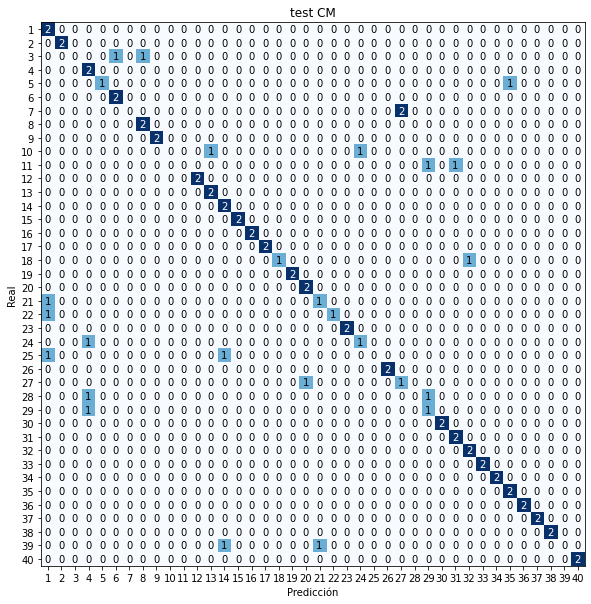

0.7375

In [33]:
# Corremos con la mejor estrategia

cols = get_cols_startwith(DATAFRAME, 'lbp', best_version, color=best_color)

run_experiment(DATAFRAME, cols, option='test', show_cm=True, method='SVM', kernel='linear')

### Probar Gabor

In [52]:
gabor_cols = [col for col in df_A.columns if col.startswith('gabor') and not col.endswith('_nonorm')]
len(gabor_cols)

67

Training...
Accuracy: train: 0.5208333333333334, val: 0.375


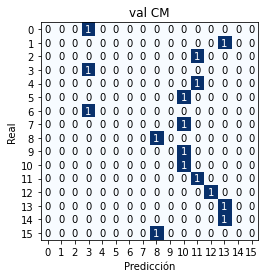

0.375

In [46]:
run_experiment(df_A, gabor_cols, method='SVM', option='val', kernel='rbf')

Training...
Accuracy: train: 0.5, val: 0.4375


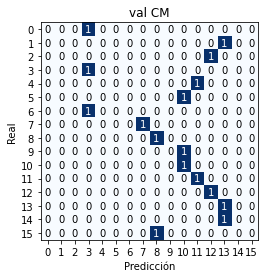

0.4375

In [47]:
run_experiment(df_A, gabor_cols, method='SVM', option='val', kernel='linear')

Training...
Accuracy: train: 0.375, val: 0.375


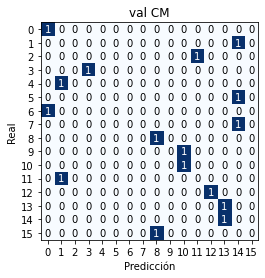

0.375

In [48]:
run_experiment(df_A, gabor_cols, method='KNN', option='val', n_neighbors=5)

Training...


/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: train: 1.0, val: 0.3125


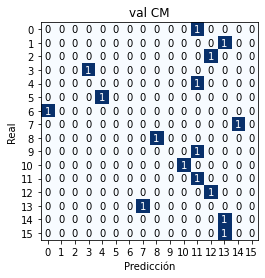

0.3125

In [49]:
run_experiment(df_A, gabor_cols, method='MLP', option='val', max_iter=1000)

### Probar HoG

In [18]:
def get_hog_cols(df, version, color=False):
    base_name = 'hog'
    if color:
        base_name += '-color'
    base_name += f'-{version}'
    return [col for col in df.columns if col.startswith(base_name) and not col.endswith('_nonorm')]

In [33]:
len(get_hog_cols(df_A, 'v1', color=True)), len(get_hog_cols(df_A, 'v10', color=False))

(4608, 0)

In [19]:
strategies = [
    { 'method': 'SVM', 'kernel': 'rbf' },
    { 'method': 'SVM', 'kernel': 'linear' },
#     { 'method': 'KNN', 'n_neighbors': 5 },
    { 'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance' },
#     { 'method': 'KNN', 'n_neighbors': 3 },
    { 'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance' },
    { 'method': 'KNN', 'n_neighbors': 1 },
#     { 'method': 'MLP' },
#     { 'method': 'RF' },
#     { 'method': 'LDA' },
]

In [20]:
hog_versions = list(HOG_CONFIGS.keys())
hog_versions

['v2', 'v5', 'v7']

In [28]:
%%time

results = []
COLOR = False
DATAFRAME = df_B

for version in hog_versions:
    hog_cols = get_hog_cols(DATAFRAME, version, color=COLOR)
    print(f'HoG version color={COLOR}+{version}, n cols = {len(hog_cols)}')

    acc, strategy = find_best_strategy(DATAFRAME, hog_cols, strategies)

    results.append((acc, strategy, version))
    
sorted_results = sorted(results, key=lambda x:x[0], reverse=True)
best_acc, best_strategy, best_version = sorted_results[0]

HoG version color=False+v2, n cols = 54288
{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.85
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.85
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.675
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.65
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.675
HoG version color=False+v5, n cols = 129600
{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.75
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.85
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.675
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.65
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.7
HoG version color

In [31]:
sorted_results

[(0.75, {'method': 'SVM', 'kernel': 'linear'}, '4-8'),
 (0.6875, {'method': 'SVM', 'kernel': 'linear'}, '4-8'),
 (0.6875, {'method': 'SVM', 'kernel': 'linear'}, '2-6'),
 (0.625, {'method': 'SVM', 'kernel': 'rbf'}, '2-6'),
 (0.625, {'method': 'SVM', 'kernel': 'rbf'}, '4-4'),
 (0.625, {'method': 'SVM', 'kernel': 'rbf'}, '4-4')]

Training...
Accuracy: train: 1.0, test: 0.8625


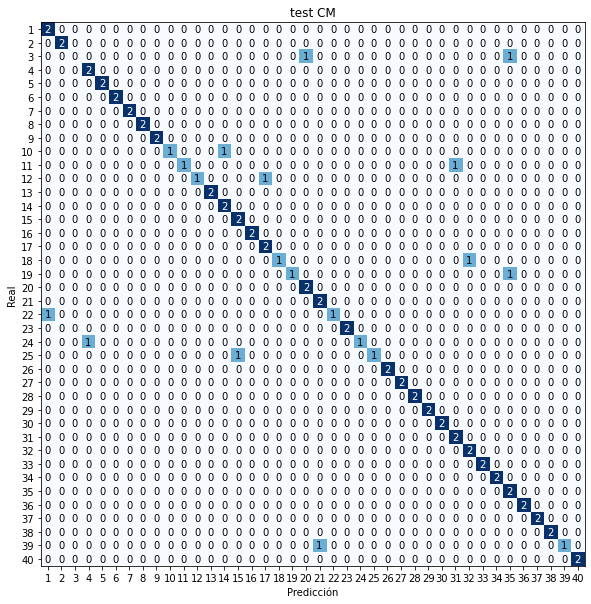

Training...
Accuracy: train: 1.0, test: 0.8375


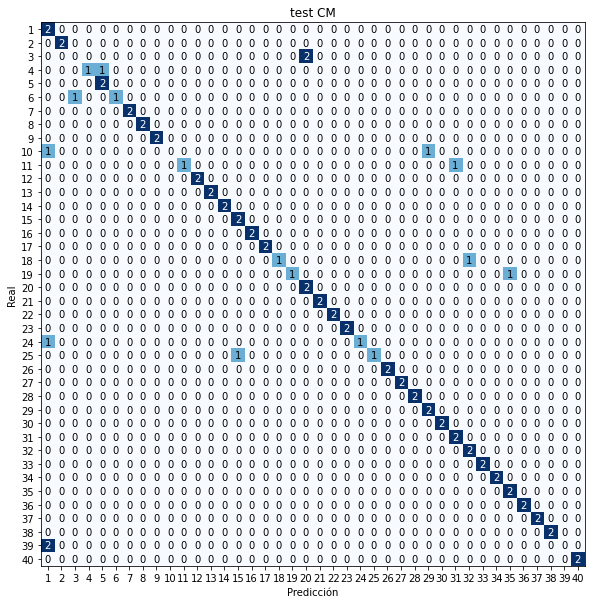

Training...
Accuracy: train: 1.0, test: 0.875


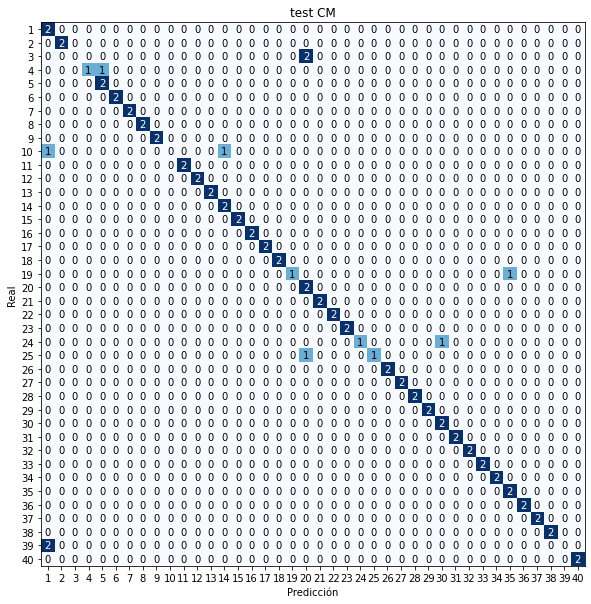

In [30]:
# print('Best results:', best_acc, best_strategy, best_version)

for version in ['v2', 'v5', 'v7']: # 'v2', 'v5',
    hog_cols = get_hog_cols(DATAFRAME, version, color=COLOR)

    run_experiment(DATAFRAME, hog_cols, option='test', show_cm=True, **best_strategy)

### Probar Haralick

In [136]:
har_cols = [col for col in df_A.columns if col.startswith('haralick') and not col.endswith('_nonorm')]
len(har_cols)

0

In [137]:
strategies = [
    { 'method': 'SVM', 'kernel': 'rbf' },
    { 'method': 'SVM', 'kernel': 'linear' },
    { 'method': 'KNN', 'n_neighbors': 5 },
    { 'method': 'KNN', 'n_neighbors': 3 },
    { 'method': 'MLP' },
]

In [138]:
best_acc, best_strategy = find_best_strategy(df_A, har_cols, strategies)

print('Best result: ', best_acc, best_strategy)

Training...


ValueError: at least one array or dtype is required

In [133]:
# Correr mejor estrategia en testing

run_experiment(df_A, har_cols, option='test', show_cm=True, ensemble = True, **best_strategy)

NameError: name 'har_cols' is not defined

### Probar SIFT

In [308]:
sift_cols = [col for col in df_A.columns if col.startswith('sift') and not col.endswith('_nonorm')]
len(sift_cols)

100

{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.1875
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.375
{'method': 'KNN', 'n_neighbors': 5}	Training...
Accuracy: train: 0.5208333333333334, val: 0.375
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.375
{'method': 'KNN', 'n_neighbors': 3}	Training...
Accuracy: train: 0.625, val: 0.4375
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.4375
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.4375
{'method': 'MLP'}	Training...
Accuracy: train: 1.0, val: 0.3125
{'method': 'RF'}	

/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training...
Accuracy: train: 1.0, val: 0.375
{'method': 'LDA'}	Training...
Accuracy: train: 0.7916666666666666, val: 0.25
Training...
Accuracy: train: 0.625, test: 0.21875


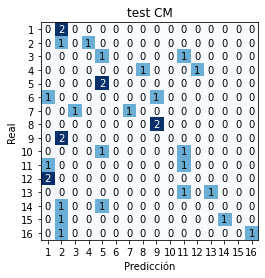

0.21875

In [309]:
best_acc, best_strategy = find_best_strategy(df_A, sift_cols, COMMON_STRATEGIES)

run_experiment(df_A, sift_cols, option='test', show_cm=True,  **best_strategy)

### Probar TAS

In [124]:
tas_cols = [col for col in df_A.columns if col.startswith('tas') and not col.endswith('_nonorm')]
best_acc, best_strategy = find_best_strategy(df_A, tas_cols, strategies)
print('Best result: ', best_acc, best_strategy)

Training...
Accuracy: train: 0.3333333333333333, val: 0.375
Training...
Accuracy: train: 0.3333333333333333, val: 0.375
Training...
Accuracy: train: 0.375, val: 0.375
Training...
Accuracy: train: 0.4583333333333333, val: 0.125
Training...
Accuracy: train: 0.2708333333333333, val: 0.25
Best result:  0.375 {'method': 'SVM', 'kernel': 'rbf'}


c:\users\yerko\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training...
Accuracy: train: 0.08333333333333333, test: 0.0625


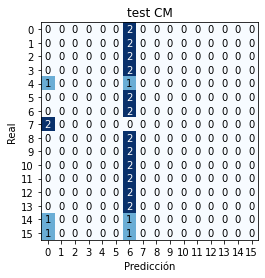

0.0625

In [132]:
run_experiment(df_A, tas_cols, option='test', show_cm=True,  **best_strategy)

Comentario: terrible *performance*, burn it with fire

### Probar SURF

In [270]:
surf_cols = [col for col in df_A.columns if col.startswith('surf') and not col.endswith('_nonorm')]
# surf_cols = [f'surf_{idx}' for idx in range(8*64)]
len(surf_cols)

100

{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.3125
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.25
{'method': 'KNN', 'n_neighbors': 5}	Training...
Accuracy: train: 0.5, val: 0.1875
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.25
{'method': 'KNN', 'n_neighbors': 3}	Training...
Accuracy: train: 0.5, val: 0.25
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.3125
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.25
{'method': 'MLP'}	Training...
Accuracy: train: 1.0, val: 0.1875
{'method': 'RF'}	

/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training...
Accuracy: train: 1.0, val: 0.125
{'method': 'LDA'}	Training...
Accuracy: train: 0.7083333333333334, val: 0.125
Training...
Accuracy: train: 1.0, test: 0.34375


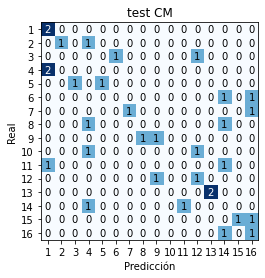

0.34375

In [271]:
best_acc, best_strategy = find_best_strategy(df_A, surf_cols, COMMON_STRATEGIES)

run_experiment(df_A, surf_cols, option='test', show_cm=True,  **best_strategy)

In [272]:
print(best_acc, best_strategy)

0.3125 {'method': 'SVM', 'kernel': 'rbf'}


### Probar Blob Detection Mean

Training...
Accuracy: train: 0.3541666666666667, val: 0.125
Training...
Accuracy: train: 0.375, val: 0.1875
Training...
Accuracy: train: 0.375, val: 0.0625
Training...
Accuracy: train: 0.2916666666666667, val: 0.0625
Training...


c:\users\yerko\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: train: 0.3333333333333333, val: 0.125
Training...
Accuracy: train: 0.4791666666666667, val: 0.1875
Best result:  0.1875 {'method': 'SVM', 'kernel': 'linear'}
Training...
Accuracy: train: 0.2916666666666667, test: 0.15625


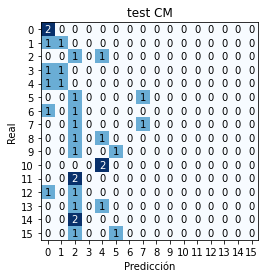

0.15625

In [145]:
blob_cols = [col for col in df_A.columns if col.startswith('blob') and not col.endswith('_nonorm')]
strategies = [
    { 'method': 'SVM', 'kernel': 'rbf' },
    { 'method': 'SVM', 'kernel': 'linear' },
    { 'method': 'KNN', 'n_neighbors': 5 },
    { 'method': 'KNN', 'n_neighbors': 3 },
    { 'method': 'MLP' },
    {'method': 'RF'}
    
]
best_acc, best_strategy = find_best_strategy(df_A, blob_cols, strategies)
print('Best result: ', best_acc, best_strategy)
run_experiment(df_A, blob_cols, option='test', show_cm=True)

### Probar Co-Ocurrence Matrix


Training...
Accuracy: train: 0.2916666666666667, val: 0.1875
Training...
Accuracy: train: 1.0, val: 0.25
Training...
Accuracy: train: 0.2916666666666667, val: 0.25
Training...
Accuracy: train: 0.4375, val: 0.125
Training...
Accuracy: train: 0.041666666666666664, val: 0.0625
Training...
Accuracy: train: 1.0, val: 0.3125
Best result:  0.3125 {'method': 'RF'}
Training...
Accuracy: train: 0.4375, test: 0.15625


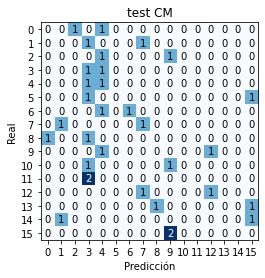

0.15625

In [144]:
co_matrix = [col for col in df_A.columns if col.startswith('matrix') and not col.endswith('_nonorm')]
strategies = [
    { 'method': 'SVM', 'kernel': 'rbf' },
    { 'method': 'SVM', 'kernel': 'linear' },
    { 'method': 'KNN', 'n_neighbors': 5 },
    { 'method': 'KNN', 'n_neighbors': 3 },
    { 'method': 'MLP' },
    {'method': 'RF'}
    
]

best_acc, best_strategy = find_best_strategy(df_A, co_matrix, strategies)
print('Best result: ', best_acc, best_strategy)
run_experiment(df_A, co_matrix, option='test', show_cm=True)

### Probar HoG SFS + PCA

In [67]:
cols

['hog-color-v2_49135',
 'hog-color-v2_20737',
 'hog-color-v2_31216',
 'hog-color-v2_31685',
 'hog-color-v2_40878',
 'hog-color-v2_11191',
 'hog-color-v2_11654',
 'hog-color-v2_20819',
 'hog-color-v2_26746',
 'hog-color-v2_9662',
 'hog-color-v2_38848',
 'hog-color-v2_23572',
 'hog-color-v2_15460',
 'hog-color-v2_942',
 'hog-color-v2_19655',
 'hog-color-v2_46439',
 'hog-color-v2_49832',
 'hog-color-v2_25348',
 'hog-color-v2_7019',
 'hog-color-v2_36510',
 'hog-color-v2_45906',
 'hog-color-v2_39509',
 'hog-color-v2_49129',
 'hog-color-v2_21700',
 'hog-color-v2_44787',
 'hog-color-v2_34062',
 'hog-color-v2_3016',
 'hog-color-v2_41789',
 'hog-color-v2_43988',
 'hog-color-v2_47145',
 'hog-color-v2_1919',
 'hog-color-v2_6689',
 'hog-color-v2_353',
 'hog-color-v2_34740',
 'hog-color-v2_40178',
 'hog-color-v2_30717',
 'hog-color-v2_39346',
 'hog-color-v2_26327',
 'hog-color-v2_48748',
 'hog-color-v2_13969',
 'hog-color-v2_13962',
 'hog-color-v2_3204',
 'hog-color-v2_40853',
 'hog-color-v2_37562'

In [71]:
sfs_cols = cols

{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.6875
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.8125
{'method': 'KNN', 'n_neighbors': 5}	Training...
Accuracy: train: 0.6666666666666666, val: 0.5
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'KNN', 'n_neighbors': 3}	Training...
Accuracy: train: 0.6666666666666666, val: 0.3125
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.5
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.4375
{'method': 'MLP'}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'RF'}	Training...
Accuracy: train: 1.0, val: 0.5
{'method': 'LDA'}	Training...
Accuracy: train: 1.0, val: 0.5
---
Best:  0.8125 {'method': 'SVM', 'kernel': 'linear'}
Training...
Accuracy: train: 1.0, test: 0.53125


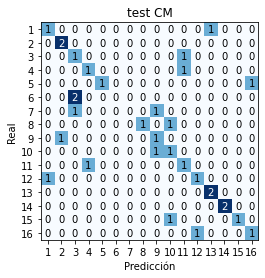

0.53125

In [70]:
acc, strategy = find_best_strategy(df_A, sfs_cols, COMMON_STRATEGIES)

print('---')
print('Best: ', acc, strategy)

run_experiment(df_A, sfs_cols, option='test', show_cm=True, **strategy)

In [65]:
pca_cols = [f'pca_{idx}' for idx in range(N_COMPONENTS)]
len(pca_cols)

20

{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.6875
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.75
{'method': 'KNN', 'n_neighbors': 5}	Training...
Accuracy: train: 0.75, val: 0.5625
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'KNN', 'n_neighbors': 3}	Training...
Accuracy: train: 0.8541666666666666, val: 0.625
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'MLP'}	Training...
Accuracy: train: 1.0, val: 0.625
{'method': 'RF'}	Training...
Accuracy: train: 1.0, val: 0.625
{'method': 'LDA'}	Training...
Accuracy: train: 1.0, val: 0.5625
---
Best:  0.75 {'method': 'SVM', 'kernel': 'linear'}
Training...
Accuracy: train: 1.0, test: 0.75


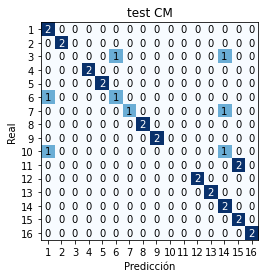

0.75

In [72]:
acc, strategy = find_best_strategy(df_A, pca_cols, COMMON_STRATEGIES)

print('---')
print('Best: ', acc, strategy)

run_experiment(df_A, pca_cols, option='test', show_cm=True, **strategy)

In [73]:
cols = sfs_cols + pca_cols

{'method': 'SVM', 'kernel': 'rbf'}	Training...
Accuracy: train: 1.0, val: 0.6875
{'method': 'SVM', 'kernel': 'linear'}	Training...
Accuracy: train: 1.0, val: 0.75
{'method': 'KNN', 'n_neighbors': 5}	Training...
Accuracy: train: 0.75, val: 0.5625
{'method': 'KNN', 'n_neighbors': 5, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'KNN', 'n_neighbors': 3}	Training...
Accuracy: train: 0.8541666666666666, val: 0.625
{'method': 'KNN', 'n_neighbors': 3, 'weights': 'distance'}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'KNN', 'n_neighbors': 1}	Training...
Accuracy: train: 1.0, val: 0.5625
{'method': 'MLP'}	Training...
Accuracy: train: 1.0, val: 0.875
{'method': 'RF'}	Training...
Accuracy: train: 1.0, val: 0.75
{'method': 'LDA'}	Training...
Accuracy: train: 0.9791666666666666, val: 0.375
---
Best:  0.875 {'method': 'MLP'}
Training...
Accuracy: train: 1.0, test: 0.65625


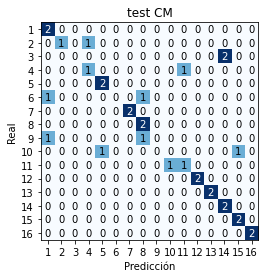

0.65625

In [74]:
acc, strategy = find_best_strategy(df_A, cols, COMMON_STRATEGIES)

print('---')
print('Best: ', acc, strategy)

run_experiment(df_A, pca_cols, option='test', show_cm=True, **strategy)